In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
review =pd.read_csv('Reviews.csv')
review.shape

(568454, 10)

In [4]:
#DROPPING ALL EXCEPT RATING AND COMMENT 
review = review[['Text','Score']].dropna()

In [5]:
review.shape

(568454, 2)

In [6]:
review.head().T

,0,1,2,3,4
Text,I have bought several of the Vitality canned d...,Product arrived labeled as Jumbo Salted Peanut...,This is a confection that has been around a fe...,If you are looking for the secret ingredient i...,Great taffy at a great price. There was a wid...
Score,5,1,4,2,5


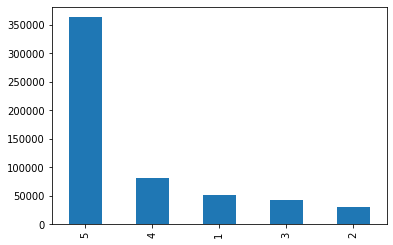

In [7]:
ax=review.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
fig.savefig("score.png");

In [8]:
#dropping the neutral values

review = review[review['Score'] != 3]

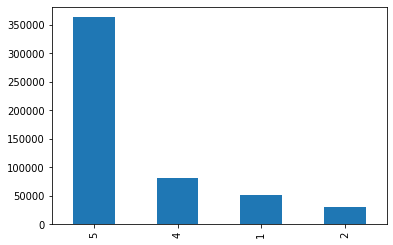

In [9]:
figs =review.Score.value_counts().plot(kind='bar')
fig = figs.get_figure()
fig.savefig("score.png");

In [10]:
review.Score[review.Score<3]=0
review.Score[review.Score>=4]=1

C:\Users\shanm\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


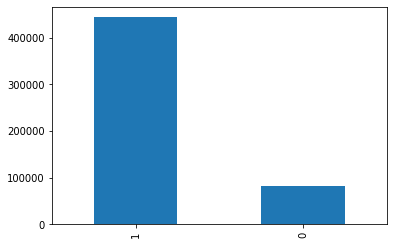

In [11]:
fig2=review.Score.value_counts().plot(kind='bar')
fig = fig2.get_figure()
fig.savefig("score_boolean.png");

In [12]:
train_pos_df=review[review.Score==1][:50000]
train_neg_df=review[review.Score==0][:50000]

In [13]:
train_df=train_pos_df.append(train_neg_df)
train_df.shape

(100000, 2)

In [14]:
spacy_tok = spacy.load('en_core_web_sm')   #tokenization
sample_review=review.Text[50]
sample_review

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [15]:
parsed_review = spacy_tok(sample_review)
parsed_review


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.

In [16]:
tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

,text,pos,tag,shape,is_alpha,is_stop,is_punctuation
0,This,DET,DT,Xxxx,True,True,False
1,oatmeal,NOUN,NN,xxxx,True,False,False
2,is,AUX,VBZ,xx,True,True,False
3,not,PART,RB,xxx,True,True,False
4,good,ADJ,JJ,xxxx,True,False,False
5,.,PUNCT,.,.,False,False,True
6,Its,DET,PRP$,Xxx,True,True,False
7,mushy,NOUN,NN,xxxx,True,False,False
8,",",PUNCT,",",",",False,False,True
9,soft,ADJ,JJ,xxxx,True,False,False


In [17]:
train_df['tuples'] = train_df.apply(
    lambda row: (row['Text'],row['Score']), axis=1)
train = train_df['tuples'].tolist()
train[:1]

[('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
  1)]

In [18]:
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=30000


#("Number of training iterations", "n", int))
n_iter=10

In [19]:
nlp = spacy.load('en_core_web_sm')
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading food reviews data...
Using 30000 examples (24000 training, 6000 evaluation)


In [20]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
8.385	0.871	0.886	0.878
3.932	0.904	0.905	0.904
2.505	0.911	0.905	0.908
1.868	0.910	0.902	0.906
1.391	0.907	0.908	0.907
1.130	0.907	0.911	0.909
0.941	0.910	0.905	0.908
0.843	0.911	0.905	0.908
0.797	0.909	0.905	0.907
0.634	0.909	0.905	0.907


In [25]:
test_text1 = " Very smooth taste and can be used again and again in the same day."
doc = nlp(test_text1)
test_text1, doc.cats

(' Very smooth taste and can be used again and again in the same day.',
 {'POSITIVE': 0.9991599321365356})

In [26]:
test_text2=" It is one of the most disgusting smelling cat foods I've ever had the displeasure of using.I wouldn't buy the duck flavor again."

In [27]:
doc = nlp(test_text2)
test_text2, doc.cats

(" It is one of the most disgusting smelling cat foods I've ever had the displeasure of using.I wouldn't buy the duck flavor again.",
 {'POSITIVE': 0.0018226009560748935})

In [30]:
test = "This is worst product I have ever seen"

In [31]:
doc = nlp(test)
test, doc.cats


('This is worst product I have ever seen', {'POSITIVE': 4.539787187241018e-05})